In [1]:
%matplotlib inline
# -*- coding: utf-8 -*-
"""
Created on Fri Apr 22 17:25:13 2016

@author: tabacof
"""

# Implements a variational autoencoder as described in Kingma et al. 2013
# "Auto-Encoding Variational Bayes"
import theano
theano.config.floatX = 'float32'
import theano.tensor as T
import numpy as np
import lasagne
import time, shutil, os
import scipy
from scipy.io import loadmat
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import pylab as plt
from read_write_model import read_model, write_model

Using gpu device 1: GeForce GTX 980 (CNMeM is disabled, cuDNN 4007)


In [2]:
#settings
do_train_model = False
batch_size = 100
num_epochs = 50
model_filename = "svhn_conv_clf"

np.random.seed(1234) # reproducibility

In [3]:
print "Using SVHN dataset"

svhn_train = loadmat('train_32x32.mat')
svhn_test = loadmat('test_32x32.mat')

train_y = svhn_train['y'].flatten() - 1
test_y = svhn_test['y'].flatten() - 1

train_x = np.rollaxis(svhn_train['X'].copy(), 3).transpose(0,3,1,2).astype(theano.config.floatX)
test_x = np.rollaxis(svhn_test['X'].copy(), 3).transpose(0,3,1,2).astype(theano.config.floatX)

svhn_mean = 115.11177966923525
svhn_std = 50.819267906232888
train_x = (train_x - svhn_mean)/svhn_std
test_x = (test_x - svhn_mean)/svhn_std

input_var = T.tensor4('inputs')
target_var = T.ivector('targets')

Using SVHN dataset


In [4]:
relu = lasagne.nonlinearities.rectify

network = lasagne.layers.InputLayer(shape=(None, 3, 32, 32),input_var=input_var)
l_noise = lasagne.layers.BiasLayer(network, b = np.zeros((3,32,32), dtype = np.float32), shared_axes = 0, name = "NOISE")
l_noise.params[l_noise.b].remove("trainable")
network = lasagne.layers.Conv2DLayer(l_noise, num_filters=32, filter_size=(3, 3), nonlinearity=relu, pad = 'same')
network = lasagne.layers.Conv2DLayer(network, num_filters=32, filter_size=(3, 3), nonlinearity=relu)
network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))
network = lasagne.layers.dropout(network, p=.25)
network = lasagne.layers.Conv2DLayer(network, num_filters=64, filter_size=(3, 3), nonlinearity=relu, pad = 'same')
network = lasagne.layers.Conv2DLayer(network, num_filters=32, filter_size=(3, 3), nonlinearity=relu)
network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))
network = lasagne.layers.dropout(network, p=.25)
network = lasagne.layers.DenseLayer(network, num_units=512, nonlinearity=relu)
network = lasagne.layers.dropout(network, p=.5)
network = lasagne.layers.DenseLayer(network, num_units=10, nonlinearity=lasagne.nonlinearities.softmax)

In [5]:
prediction = lasagne.layers.get_output(network)
loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
loss = loss.mean()

params = lasagne.layers.get_all_params(network, trainable=True)
updates = lasagne.updates.nesterov_momentum(loss, params, 0.01, 0.9)

test_prediction = lasagne.layers.get_output(network, deterministic=True)
test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,
                                                        target_var)
test_loss = test_loss.mean()
test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
                  dtype=theano.config.floatX)

train_fn = theano.function([input_var, target_var], loss, updates=updates)

val_fn = theano.function([input_var, target_var], [test_loss, test_acc])

In [6]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [7]:
if do_train_model:
    # Finally, launch the training loop.
    print("Starting training...")
    # We iterate over epochs:
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_err = 0
        train_batches = 0
        start_time = time.time()
        for batch in iterate_minibatches(train_x, train_y, batch_size, shuffle=True):
            tr_inputs, tr_targets = batch
            train_err += train_fn(tr_inputs, tr_targets)
            train_batches += 1

        # And a full pass over the validation data:
        val_err = 0
        val_acc = 0
        val_batches = 0
        for batch in iterate_minibatches(test_x, test_y, batch_size, shuffle=False):
            inputs, targets = batch
            err, acc = val_fn(inputs, targets)
            val_err += err
            val_acc += acc
            val_batches += 1

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
        print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
        print("  validation accuracy:\t\t{:.2f} %".format(
            val_acc / val_batches * 100))
    write_model([network], model_filename)
else:
    read_model([network], model_filename)

In [29]:
def show_svhn(img, i, title=""): # expects flattened image of shape (3072,) 
    img = img.copy().reshape(3,32,32).transpose(1,2,0)
    img *= svhn_std
    img += svhn_mean
    img /= 255.0
    img = np.clip(img, 0, 1)
    plt.subplot(2, 1, i)
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")

In [30]:
# Adversarial confusion cost function
adv_confusion = lasagne.objectives.categorical_crossentropy(test_prediction, target_var).mean()

# Adversarial regularization
regC = T.scalar()
adv_reg = regC*lasagne.regularization.l2(l_noise.b)
# Total adversarial loss
adv_loss = adv_confusion + adv_reg
adv_grad = T.grad(adv_loss, l_noise.b)

# Function used to optimize the adversarial noise
adv_function = theano.function([input_var, target_var, regC], [adv_loss, adv_grad, test_prediction])

In [77]:
def adv_test(orig_img, adv_label, C, plot = True):
    # Set the adversarial noise to zero
    l_noise.b.set_value(np.zeros((3,32,32)).astype(np.float32))

    _, _, orig_pred = adv_function(test_x[orig_img][np.newaxis, :, :, :], [adv_label], C)

    # Initialize the adversarial noise for the optimization procedure
    l_noise.b.set_value(np.random.uniform(-1e-8, 1e-8, size=(3,32,32)).astype(np.float32))

    # Optimization function for L-BFGS-B
    def fmin_func(x):
        l_noise.b.set_value(x.reshape(3, 32, 32).astype(np.float32))
        f, g, _ = adv_function(test_x[orig_img][np.newaxis, :, :, :], [adv_label], C)
        return float(f), g.flatten().astype(np.float64)

    # Noise bounds (pixels cannot exceed 0-1)
    bounds = zip(-svhn_mean/svhn_std-test_x[orig_img].flatten(), (255.0-svhn_mean)/svhn_std-test_x[orig_img].flatten())

    # L-BFGS-B optimization to find adversarial noise
    x, f, d = scipy.optimize.fmin_l_bfgs_b(fmin_func, l_noise.b.get_value().flatten(), bounds = bounds, fprime = None, factr = 10, m = 25)
    l_noise.b.set_value(x.reshape(3, 32, 32).astype(np.float32))
    
    adv_loss, _, adv_pred = adv_function(test_x[orig_img][np.newaxis, :, :, :], [adv_label], C)

    if plot:
        plt.figure()
        show_svhn(test_x[orig_img], 1, "Original")
        show_svhn(test_x[orig_img] + x.reshape(3, 32, 32), 2, "Adversarial")
        plt.show()
            
    return adv_loss, np.linalg.norm(x), test_y[orig_img], np.argmax(orig_pred), np.argmax(adv_pred), adv_pred[0][test_y[orig_img]], adv_pred[0][adv_label]

In [78]:
def orig_adv_dist(orig_img = None, adv_label = None, plot = False):
    if orig_img is None:
        orig_img = np.random.randint(0, len(test_x))
        _, _, pred = adv_function(test_x[orig_img][np.newaxis, :], [0], 0.0)
        print(np.argmax(pred), test_y[orig_img], pred)
        while np.argmax(pred) != test_y[orig_img]:
            orig_img = np.random.randint(0, len(test_x))
            _, _, pred = adv_function(test_x[orig_img][np.newaxis, :], [0], 0.0)
            print(np.argmax(pred), test_y[orig_img], pred)

    if adv_label is None:
        adv_label = test_y[orig_img]
        while adv_label ==  test_y[orig_img]:
            adv_label = np.random.randint(0, 10)

    print "Img",orig_img, "Adv label", adv_label
    
    adv_loss=[]
    adv_norm=[]
    orig_prob=[]
    adv_prob=[]
    adv = []
    
    C = np.logspace(-10, 20, 100, base = 2, dtype = np.float32)
    plot_intersection = plot
    
    for i, c in enumerate(C):
        plot_current = plot and (i == 0 or i == 49)
        od, ad, ol, op, ap, o_prob, a_prob = adv_test(orig_img, adv_label, C=c, plot = plot_current)
        if plot_current:
            print ad, o_prob, a_prob
        if plot_intersection and o_prob >= a_prob:
            adv_test(orig_img, adv_label, C=C[i-1], plot = True)
            plot_intersection = False
            print ad, o_prob, a_prob
        adv_loss.append(od)
        adv_norm.append(ad)
        adv.append(ap == adv_label)
        orig_prob.append(o_prob)
        adv_prob.append(a_prob)
        
    adv_loss = np.array(adv_loss)
    adv_norm = np.array(adv_norm)
    orig_prob = np.array(orig_prob)
    adv_prob = np.array(adv_prob)

    if plot:
        plt.figure()
        plt.scatter([adv_norm[i] for i, x in enumerate(adv) if x], [adv_loss[i] for i, x in enumerate(adv) if x], c='red', label = "Adversarial")
        plt.scatter([adv_norm[i] for i, x in enumerate(adv) if not x], [adv_loss[i] for i, x in enumerate(adv) if not x], c='blue', label = "Non-adversarial")
        plt.ylabel("Adversarial cross-entropy")
        plt.xlabel("Distortion")
        plt.title("SVHN")
        plt.legend(loc=3, prop={'size':9})
        plt.show()
        plt.figure()
        plt.scatter(adv_norm, adv_prob, c='red', label = "Adversarial")
        plt.scatter(adv_norm, orig_prob, c='blue', label = "Original")
        plt.ylabel("Probability")
        plt.xlabel("Distortion")
        plt.title("SVHN")
        plt.legend(loc=3, prop={'size':9})
        plt.show()
        plt.figure()
        plt.scatter(adv_norm, scipy.special.logit(adv_prob), c='red', label = "Adversarial")
        plt.scatter(adv_norm, scipy.special.logit(orig_prob), c='blue', label = "Original")
        plt.ylabel("Logit")
        plt.xlabel("Distortion")
        plt.title("SVHN")
        plt.legend(loc=3, prop={'size':9})
        plt.show()
        
    return adv_norm, adv_loss, adv_prob, orig_prob

(1, 1, array([[  3.56896720e-07,   9.78084326e-01,   2.65006724e-06,
          2.04791922e-05,   2.20643344e-07,   5.48082710e-07,
          2.18858384e-02,   5.69159608e-09,   1.99053557e-06,
          3.51864924e-06]], dtype=float32))
Img 21191 Adv label 9


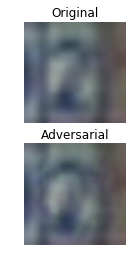

2.82588950643 0.000359912 0.999379


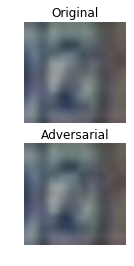

1.23279186704 0.349308 0.292681


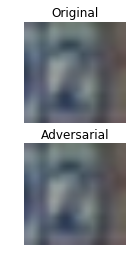

0.216917826556 0.922118 6.48804e-05


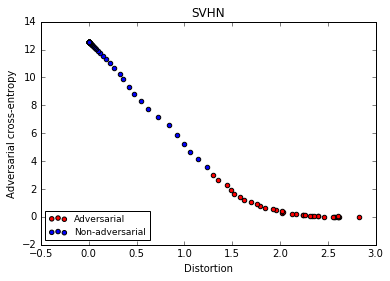

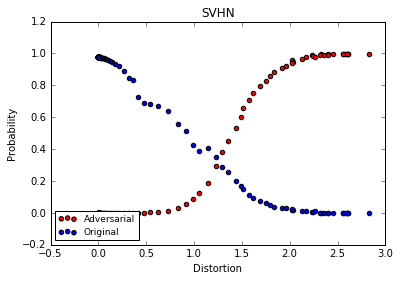

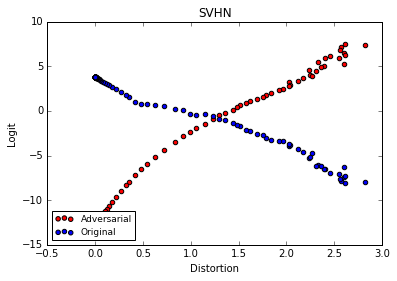

(6, 6, array([[  3.00277378e-07,   1.26435515e-10,   1.41022710e-07,
          1.69602717e-11,   1.83790396e-11,   3.62240321e-13,
          9.99999523e-01,   6.13206643e-13,   9.53298329e-10,
          3.40379309e-12]], dtype=float32))
Img 11541 Adv label 8


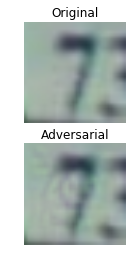

3.09368806759 0.000427 0.999558


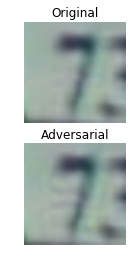

1.88407207653 0.486008 0.47951


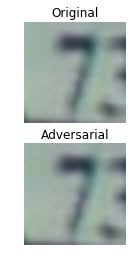

0.176847542811 0.999999 5.75951e-09


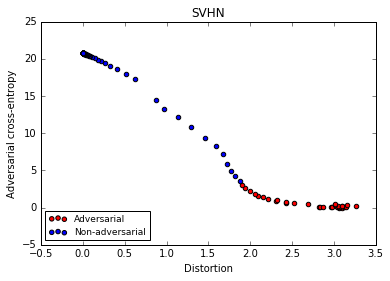

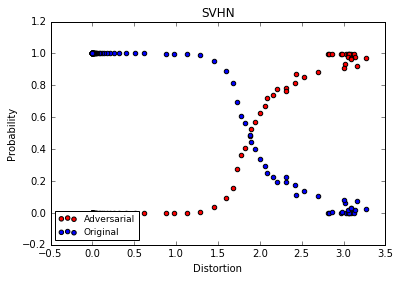

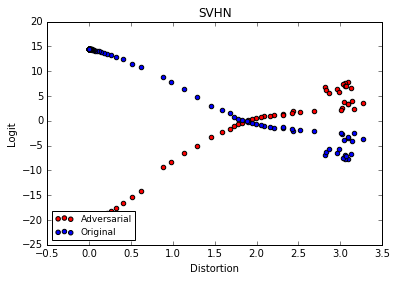

(1, 1, array([[  3.99109349e-02,   9.59469795e-01,   1.22620247e-06,
          3.81788239e-04,   3.79637299e-07,   1.38343443e-08,
          2.35813161e-04,   6.81837919e-11,   1.32498112e-09,
          1.58449449e-08]], dtype=float32))
Img 301 Adv label 5


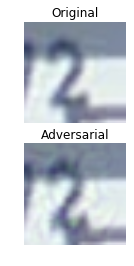

6.03552148049 0.000404127 0.992925


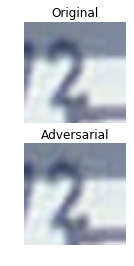

2.39079064747 0.187995 0.121054


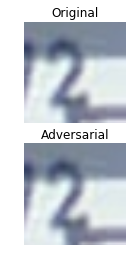

0.161794505415 0.924984 6.25394e-08


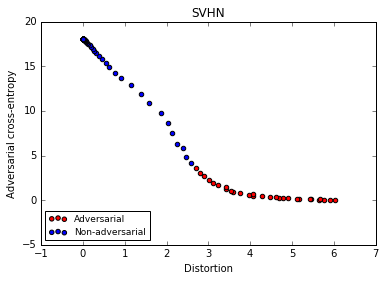

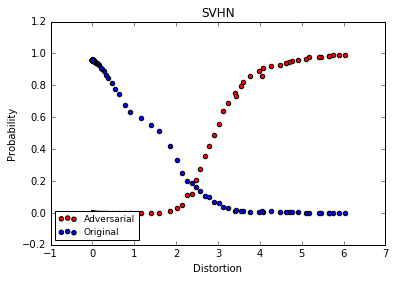

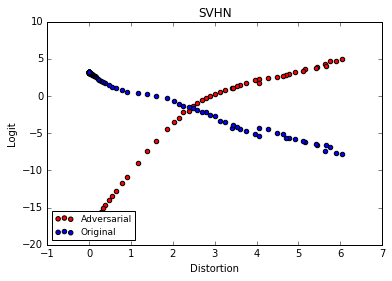

(0, 0, array([[  1.00000000e+00,   2.08536205e-13,   9.38310437e-14,
          1.23697205e-10,   1.19346993e-14,   3.02684635e-13,
          2.24955297e-11,   1.06169937e-15,   3.37980493e-16,
          6.38195847e-19]], dtype=float32))
Img 18016 Adv label 2


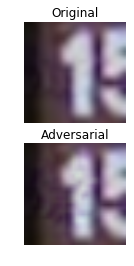

4.0147866139 0.000771191 0.999159


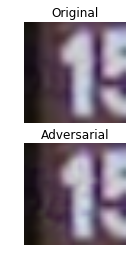

3.00953129077 0.656958 0.219126


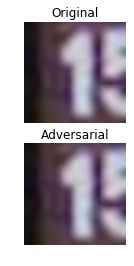

0.249040797542 1.0 4.41446e-12


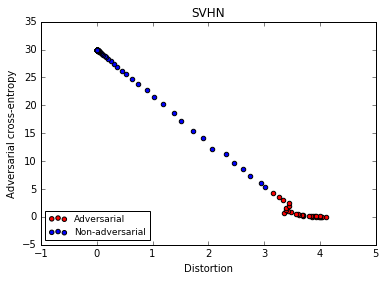

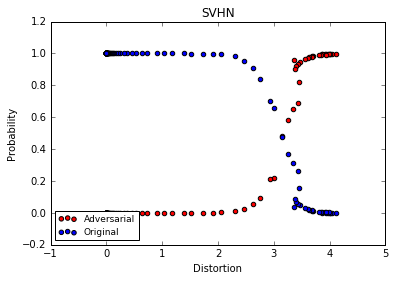

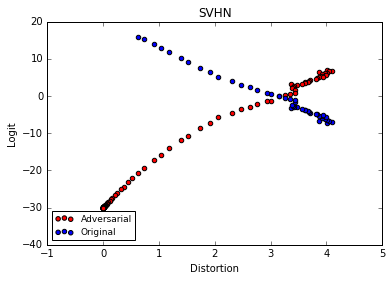

(5, 5, array([[  1.02096426e-04,   2.12018167e-05,   2.08275349e-04,
          2.47383905e-05,   8.54779151e-04,   9.89816785e-01,
          2.10937424e-06,   7.97075778e-03,   9.70211840e-06,
          9.89576103e-04]], dtype=float32))
Img 10967 Adv label 4


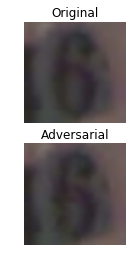

1.34495485522 8.02453e-05 0.999845


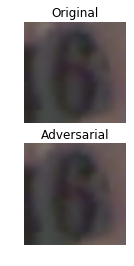

0.801205506751 0.587261 0.318874


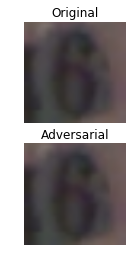

0.181903264886 0.954889 0.00777388


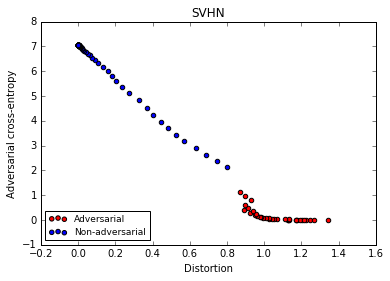

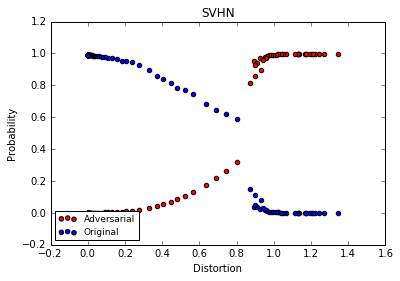

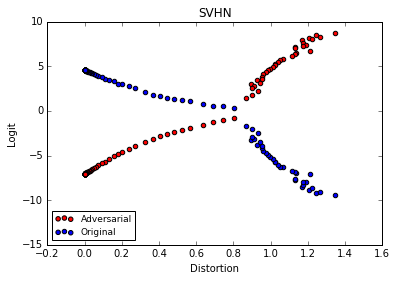

(9, 9, array([[  1.19689003e-09,   9.50749290e-06,   1.28125448e-08,
          7.64858044e-09,   1.30188490e-11,   6.64510435e-06,
          5.42243195e-11,   3.56783357e-06,   9.61175247e-04,
          9.99019027e-01]], dtype=float32))
Img 17930 Adv label 5


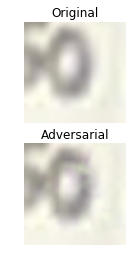

3.41098904511 0.00105299 0.9986


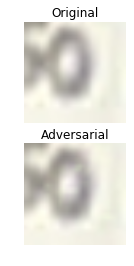

1.71107480822 0.473144 0.438796


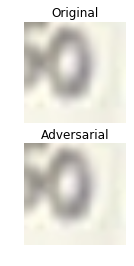

0.123900335804 0.998667 1.6647e-05


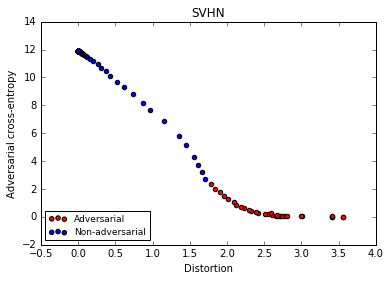

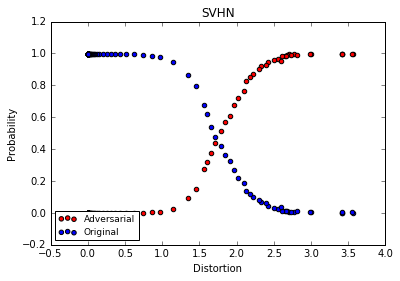

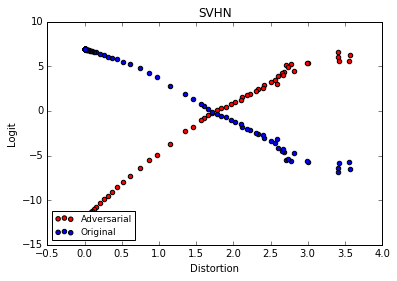

(0, 0, array([[  9.99984980e-01,   7.98248223e-09,   2.38376217e-07,
          1.87505460e-08,   6.46878495e-10,   2.47551970e-08,
          3.37324877e-07,   1.93620995e-08,   2.46818303e-07,
          1.42388626e-05]], dtype=float32))
Img 24143 Adv label 3


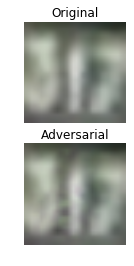

2.80883504433 0.00047196 0.999401


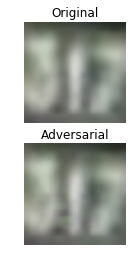

2.01656415739 0.671464 0.303008


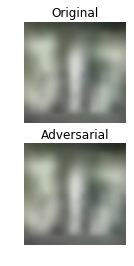

0.156242957026 0.999971 8.12081e-08


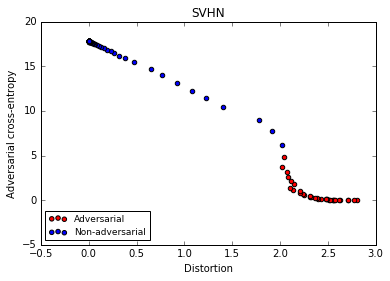

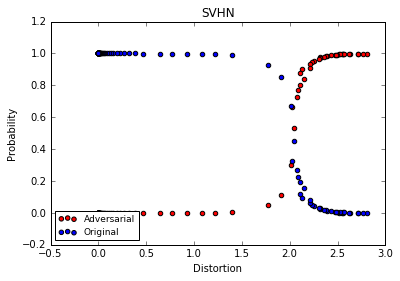

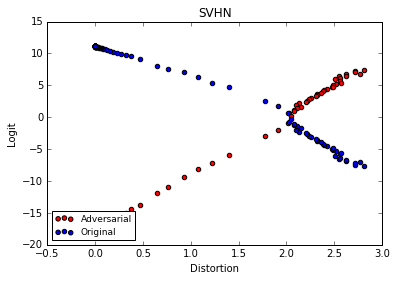

(5, 5, array([[  3.72975784e-09,   1.11437934e-11,   5.05268154e-11,
          4.55716086e-13,   1.63862078e-05,   9.99983549e-01,
          9.74554049e-11,   1.17420278e-08,   7.77033732e-12,
          7.06689747e-08]], dtype=float32))
Img 23560 Adv label 6


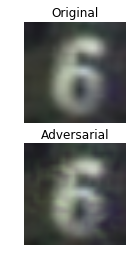

4.32124003465 0.000727364 0.997902


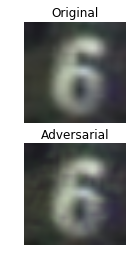

2.93088368594 0.501217 0.334864


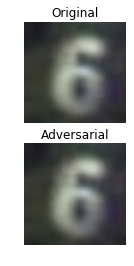

0.157528758647 0.999969 4.04257e-10


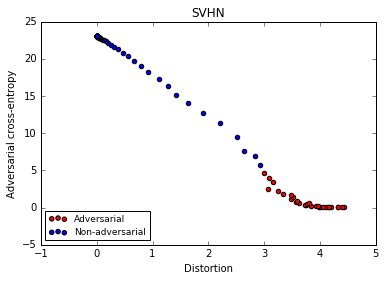

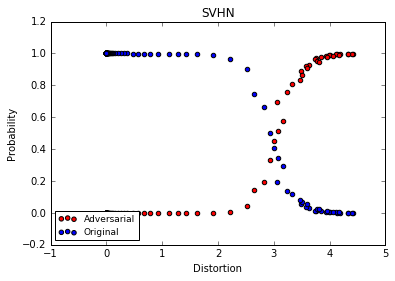

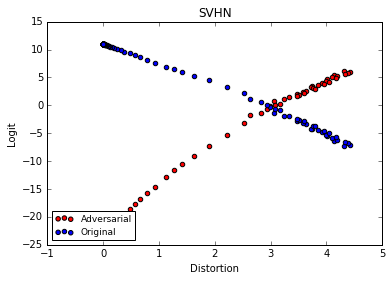

(2, 2, array([[  8.92400408e-07,   5.22194625e-08,   9.99987245e-01,
          8.44533610e-10,   9.94695984e-06,   5.10769371e-10,
          1.08069582e-06,   7.22727520e-07,   9.16953766e-08,
          5.17112708e-09]], dtype=float32))
Img 17274 Adv label 3


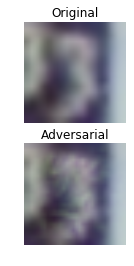

4.46371670087 0.000359085 0.998707


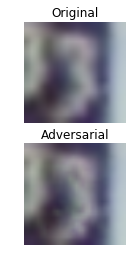

2.09899335818 0.232109 0.135384


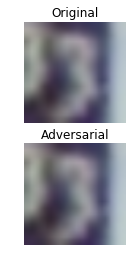

0.218962562985 0.999935 1.52999e-08


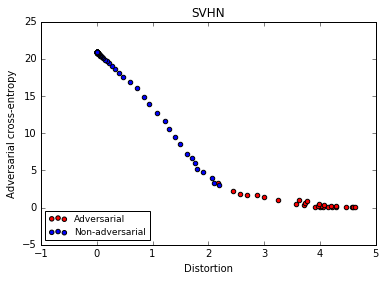

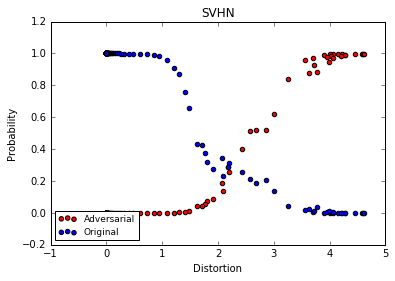

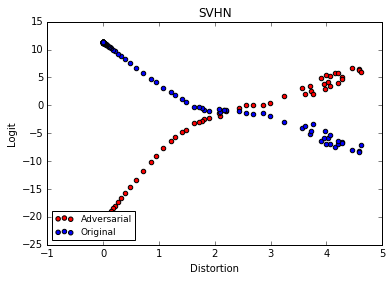

(0, 0, array([[  9.99999762e-01,   1.46600854e-09,   4.12850731e-09,
          2.27109487e-09,   4.80052942e-11,   2.90601043e-10,
          2.01261528e-07,   2.76797422e-12,   2.72914035e-11,
          2.94550322e-12]], dtype=float32))
Img 7609 Adv label 9


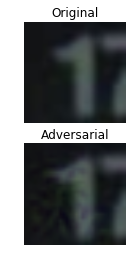

3.52500027925 0.00091478 0.998963


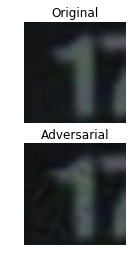

2.41403222764 0.43707 0.187355


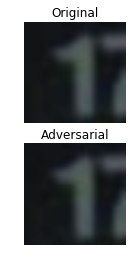

0.23503230741 0.999999 7.33197e-11


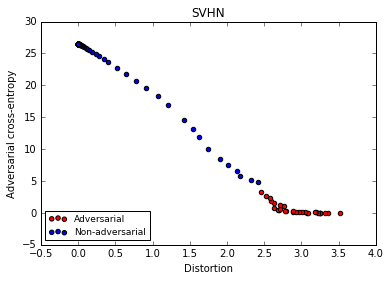

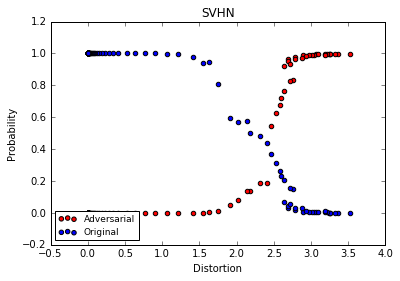

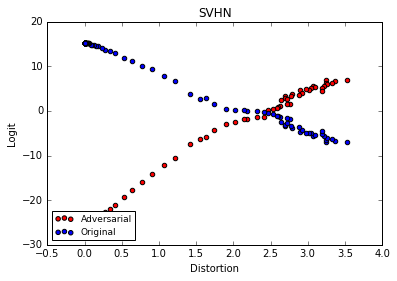

(2, 2, array([[  1.92737598e-02,   3.66026325e-05,   9.78597820e-01,
          2.02976244e-05,   5.91822551e-04,   4.43548161e-05,
          1.29275094e-03,   3.36781086e-05,   9.51154561e-06,
          9.93242720e-05]], dtype=float32))
Img 5273 Adv label 6


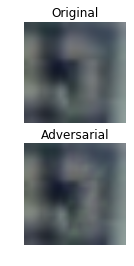

1.68544242273 0.000116522 0.999744


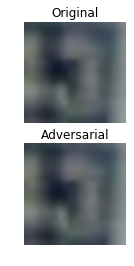

0.630843187169 0.373996 0.368627


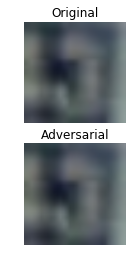

0.196001977774 0.890603 0.0130942


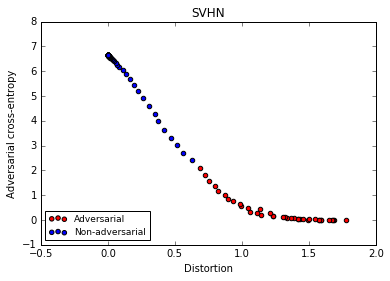

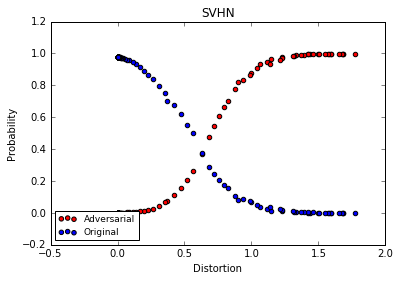

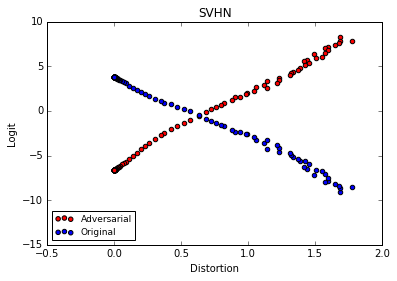

(8, 8, array([[  6.66003558e-04,   1.00303011e-03,   7.75604101e-04,
          1.53760993e-05,   1.16621311e-04,   3.10679241e-07,
          1.72908040e-06,   4.40445874e-05,   9.97050762e-01,
          3.26489826e-04]], dtype=float32))
Img 6015 Adv label 2


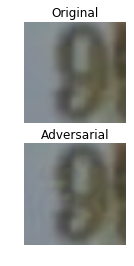

1.75556241915 0.000186797 0.999704


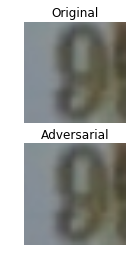

0.691778956967 0.464838 0.438898


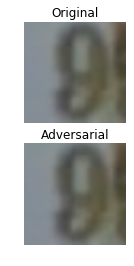

0.166704595209 0.989147 0.00438644


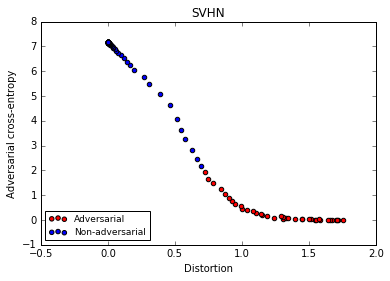

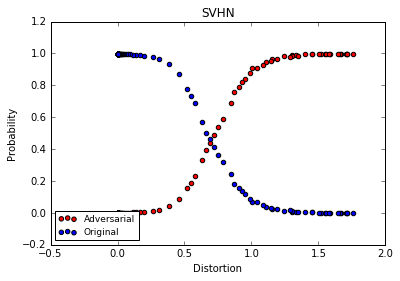

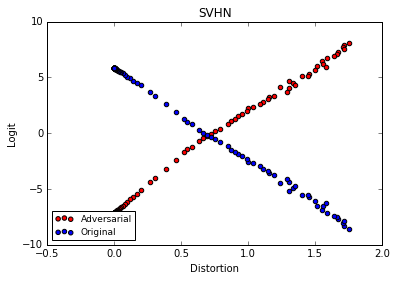

(5, 5, array([[  4.82143651e-06,   1.15071050e-10,   1.64059657e-06,
          8.59518991e-07,   4.64674449e-05,   9.99943256e-01,
          7.17009507e-10,   1.79357596e-06,   4.04870018e-12,
          1.15707019e-06]], dtype=float32))
Img 784 Adv label 0


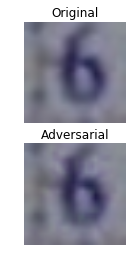

2.54623078816 0.000320868 0.999466


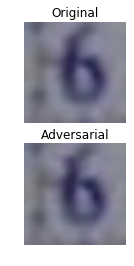

1.54972204654 0.459127 0.374365


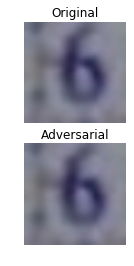

0.187929774721 0.999773 3.74126e-05


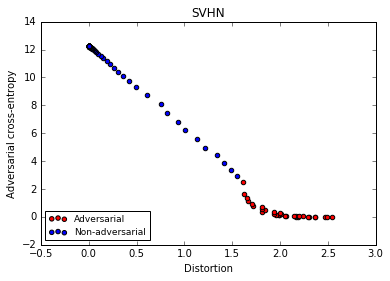

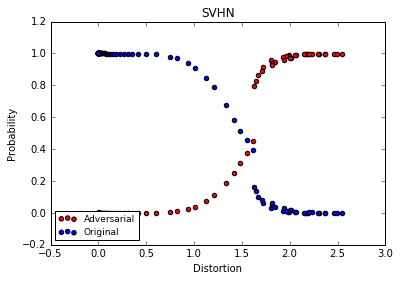

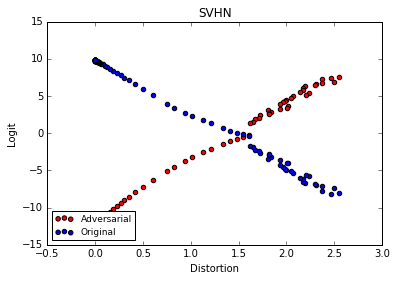

(7, 7, array([[  2.72478502e-07,   2.99492876e-05,   9.30805300e-07,
          2.88501354e-07,   6.88877117e-06,   6.98601874e-03,
          2.54602756e-10,   9.14421678e-01,   3.89613281e-03,
          7.46578276e-02]], dtype=float32))
Img 17987 Adv label 1


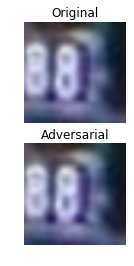

2.85225708803 0.000339997 0.999203


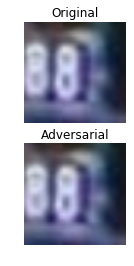

1.58854542186 0.43575 0.348008


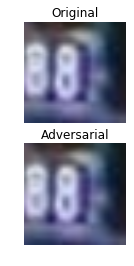

0.126491579966 0.895724 7.56822e-05


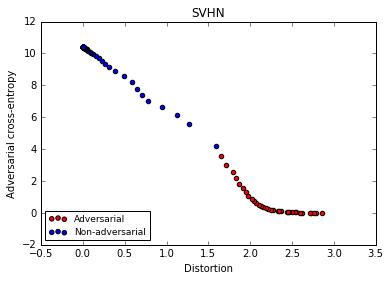

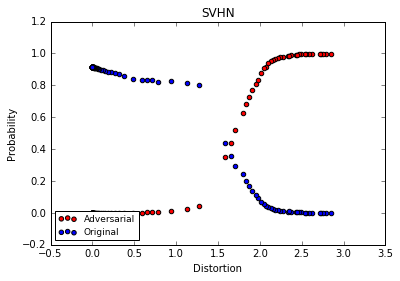

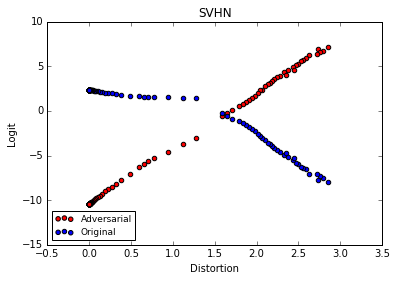

(0, 0, array([[  9.99997973e-01,   4.74470463e-09,   1.08269960e-09,
          1.96194128e-06,   1.36751688e-09,   1.97692596e-09,
          1.36888957e-07,   7.70890995e-09,   2.19484129e-08,
          3.98156952e-10]], dtype=float32))
Img 20431 Adv label 6


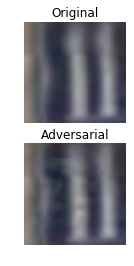

3.21217683423 0.000869861 0.999091


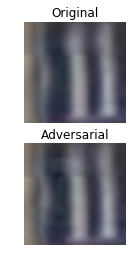

2.10929752804 0.606845 0.392449


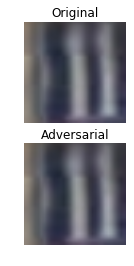

0.176919585503 0.999995 9.82617e-07


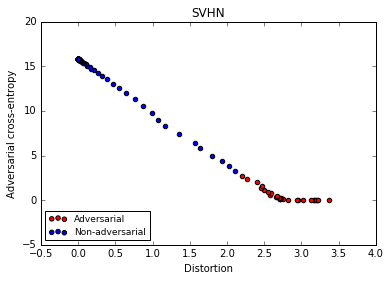

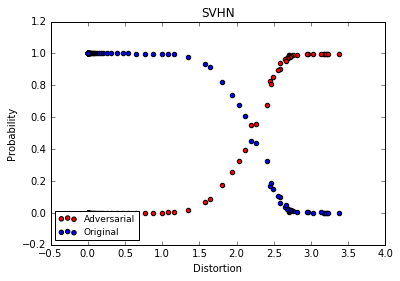

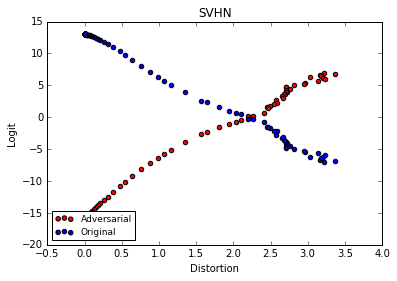

(8, 8, array([[  2.14407467e-11,   1.03247174e-07,   3.34550443e-11,
          7.81243585e-08,   1.10618288e-13,   5.70640020e-12,
          2.82571059e-15,   2.01514410e-07,   9.99999523e-01,
          1.42867592e-07]], dtype=float32))
Img 17550 Adv label 1


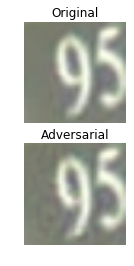

3.59482611413 0.00120777 0.998749


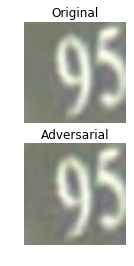

2.24008684936 0.522276 0.468336


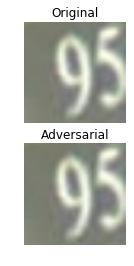

0.141400438899 0.999999 3.27916e-07


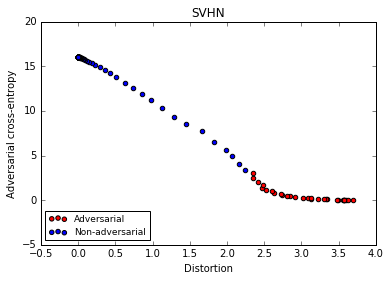

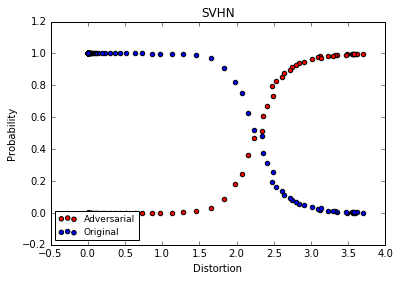

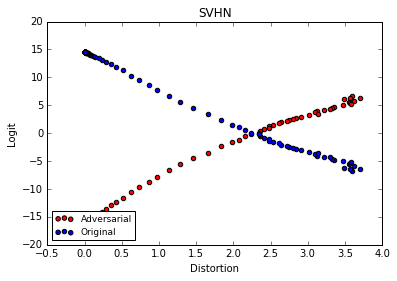

(4, 4, array([[  3.53605969e-07,   8.41202805e-08,   7.77763098e-09,
          1.26227677e-08,   9.99993801e-01,   2.74469727e-07,
          5.25068117e-06,   3.43872361e-11,   2.09089464e-07,
          8.57844906e-09]], dtype=float32))
Img 4146 Adv label 5


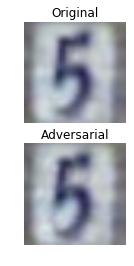

3.84780902172 0.00110211 0.998898


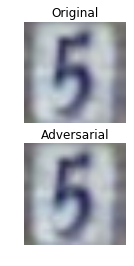

2.48516159633 0.58579 0.413847


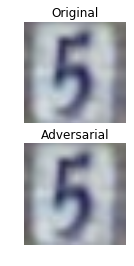

0.136758613974 0.999992 7.40981e-07


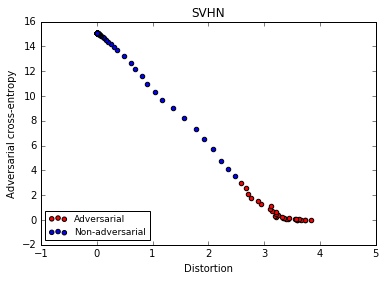

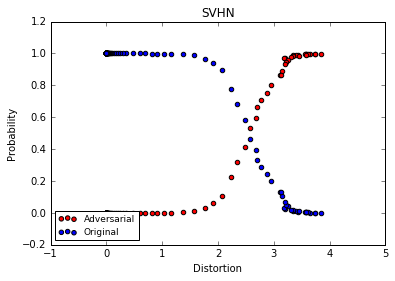

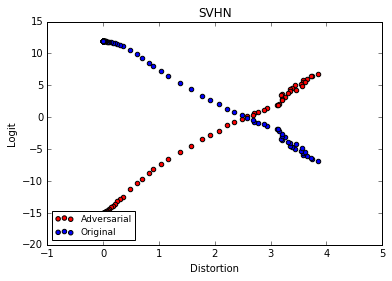

(3, 3, array([[  2.23825987e-06,   1.25215429e-05,   5.34166986e-07,
          9.99983311e-01,   3.75299948e-07,   5.53484597e-07,
          9.12571068e-08,   2.57329731e-07,   1.73109896e-07,
          3.29480954e-09]], dtype=float32))
Img 12915 Adv label 6


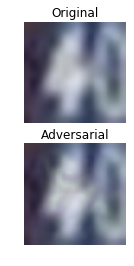

3.30507876517 0.000574862 0.998682


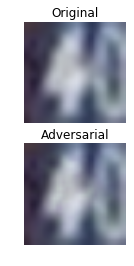

1.98336841851 0.48097 0.402194


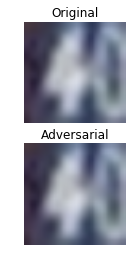

0.165870447179 0.999948 4.90076e-07


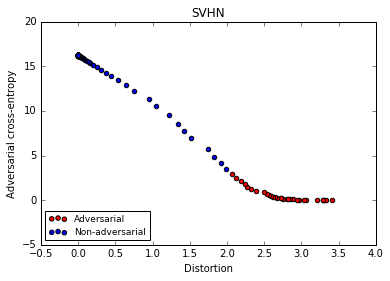

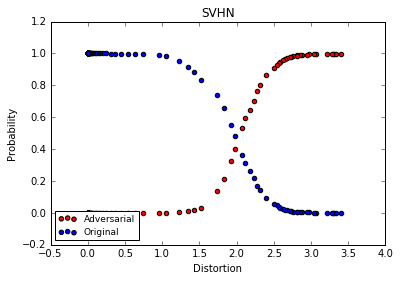

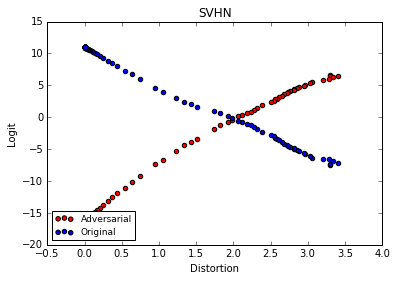

(8, 8, array([[  2.30433880e-10,   6.10597226e-06,   1.36549147e-10,
          2.95941660e-10,   2.26573480e-13,   7.55022193e-16,
          2.66898266e-12,   2.84700458e-10,   9.99993920e-01,
          3.97077149e-10]], dtype=float32))
Img 20949 Adv label 4


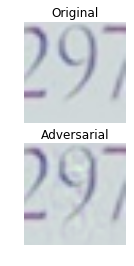

4.33291709412 0.00088099 0.998931


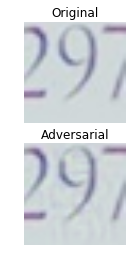

3.12144435813 0.467319 0.40586


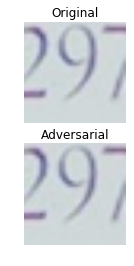

0.194642330971 0.999977 1.81278e-12


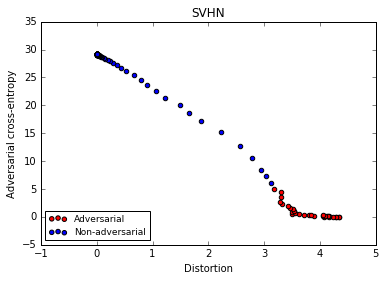

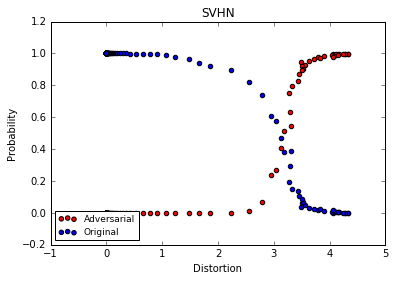

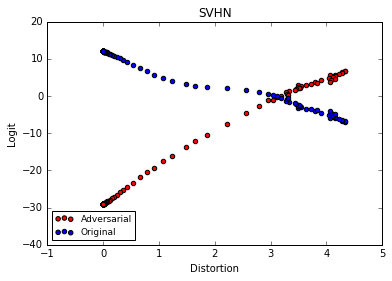

(5, 5, array([[  1.65800384e-06,   5.87163251e-09,   4.17636329e-06,
          2.50848742e-09,   5.21131675e-04,   9.99461114e-01,
          3.54333229e-09,   1.15757693e-05,   7.56031737e-10,
          4.08036698e-07]], dtype=float32))
Img 10397 Adv label 7


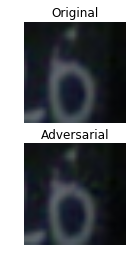

1.98255973957 0.000293104 0.999611


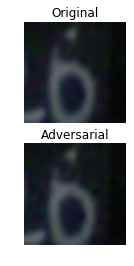

0.954964107876 0.527486 0.387342


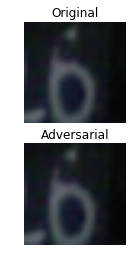

0.200254580537 0.998004 0.000154185


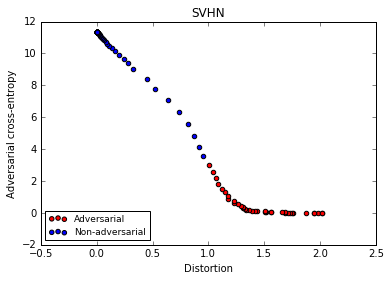

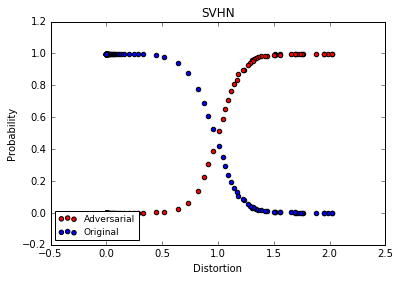

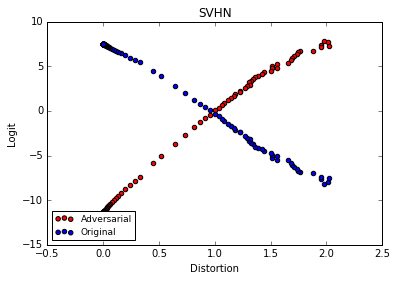

(6, 6, array([[  1.68087672e-06,   1.01571634e-14,   3.20219719e-11,
          7.24568799e-12,   2.88286669e-11,   2.16538020e-11,
          9.99998331e-01,   9.65556454e-12,   9.42090069e-12,
          6.05277005e-13]], dtype=float32))
Img 11092 Adv label 9


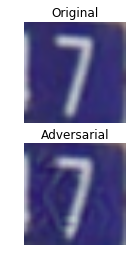

5.38730453387 0.00122461 0.998612


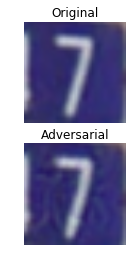

4.24789387636 0.636003 0.314967


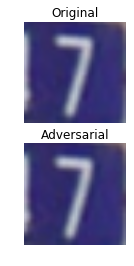

0.134672236091 0.999997 1.83387e-12


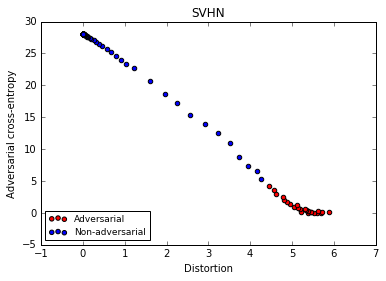

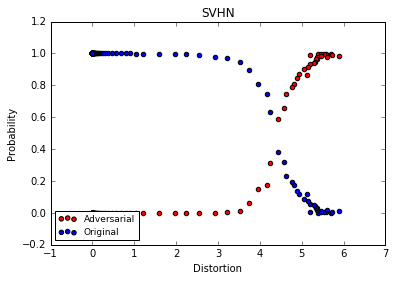

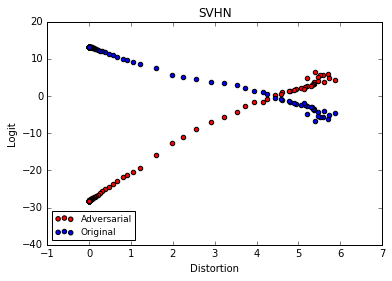

(6, 6, array([[  2.86908835e-01,   2.66109328e-05,   1.03812075e-04,
          1.06990301e-05,   6.30547959e-07,   5.64448010e-06,
          7.12912023e-01,   9.87485691e-06,   1.80950465e-05,
          3.84015175e-06]], dtype=float32))
Img 1978 Adv label 5


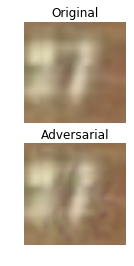

3.5130262947 5.46978e-05 0.998701


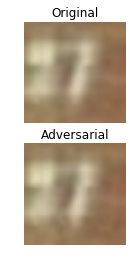

1.23745658568 0.199242 0.168372


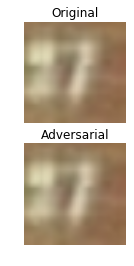

0.19515276425 0.632377 5.24793e-05


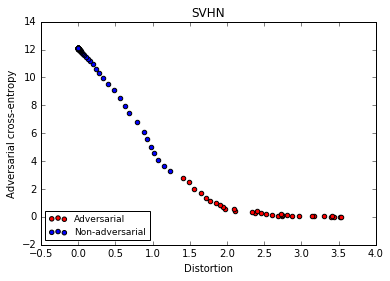

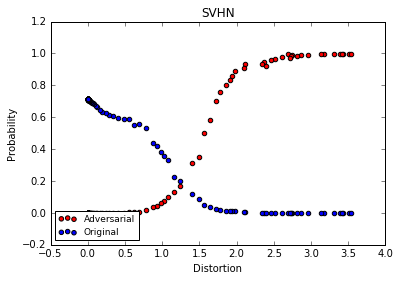

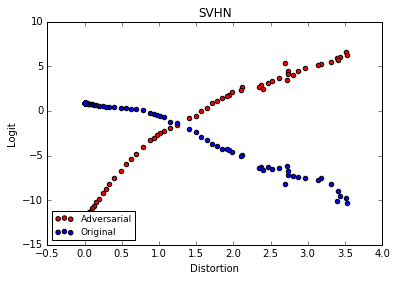

(0, 3, array([[  8.49143028e-01,   1.43512270e-05,   8.06629032e-05,
          1.50397822e-01,   1.93416301e-04,   9.99834519e-05,
          2.72279103e-05,   1.74769229e-05,   8.51776440e-06,
          1.73005501e-05]], dtype=float32))
(0, 0, array([[  9.99908686e-01,   9.73789383e-07,   1.24998849e-06,
          7.45962666e-07,   8.97186325e-09,   7.92146722e-08,
          8.59568172e-05,   1.17281309e-06,   5.65491916e-07,
          6.26776625e-07]], dtype=float32))
Img 6313 Adv label 8


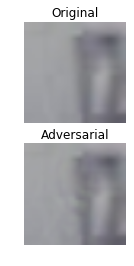

1.44359779823 7.77207e-05 0.99982


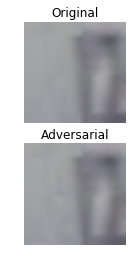

0.776543032277 0.488157 0.462722


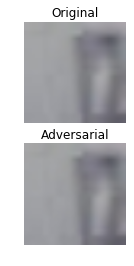

0.251736288186 0.999637 3.59901e-05


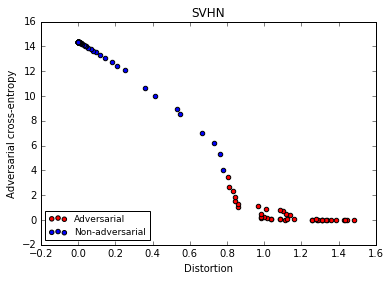

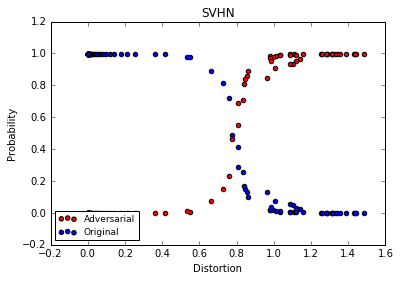

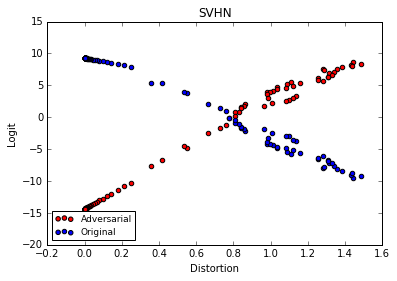

(8, 8, array([[  3.75454729e-05,   1.38227986e-02,   1.61824778e-01,
          5.68945259e-02,   4.84468602e-03,   5.21303527e-02,
          1.94345121e-05,   3.61321028e-03,   7.03607261e-01,
          3.20531870e-03]], dtype=float32))
Img 9986 Adv label 7


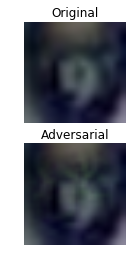

2.90350208185 4.77919e-05 0.999157


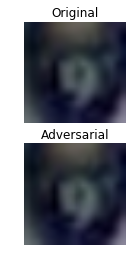

0.642105983444 0.229375 0.165486


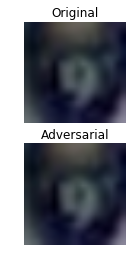

0.134833395036 0.542791 0.0107639


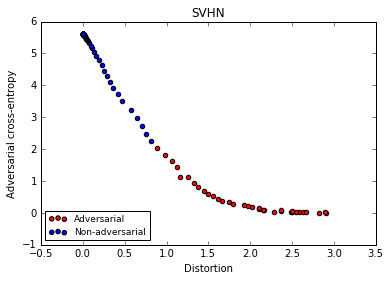

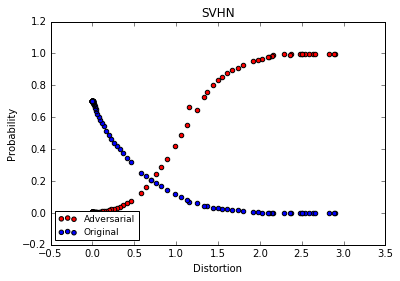

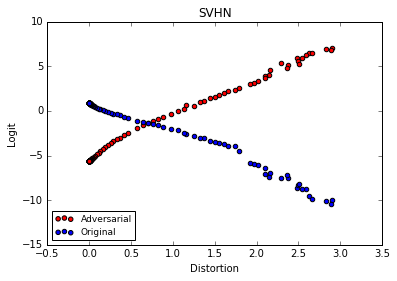

(6, 6, array([[  1.14939369e-09,   1.39807870e-20,   1.69850991e-11,
          1.95716341e-13,   1.53297685e-15,   2.13271122e-15,
          1.00000000e+00,   3.15799128e-17,   3.53213030e-16,
          1.81112360e-16]], dtype=float32))
Img 2018 Adv label 8


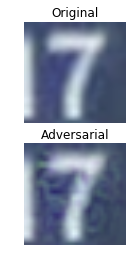

7.40657181194 0.00621167 0.993691


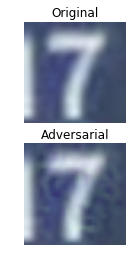

5.13285568612 0.457807 0.451497


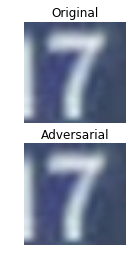

0.157936565894 1.0 1.57596e-15


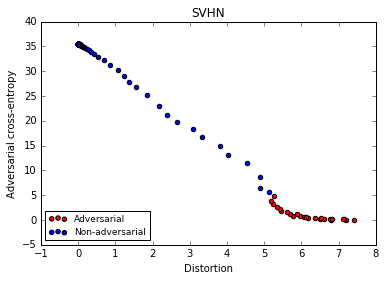

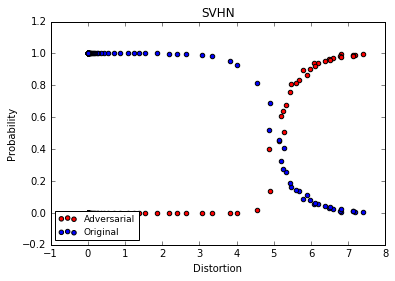

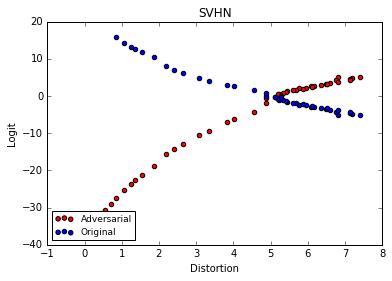

In [80]:
n = 25

adv_norm = []
adv_prob = []
orig_prob = []

for i in range(n):
    an, _, ap, op = orig_adv_dist(plot = True)
    adv_norm.append(an)
    adv_prob.append(ap)
    orig_prob.append(op)
    
adv_norm = np.array(adv_norm)
adv_prob = np.array(adv_prob)
adv_prob_logit = scipy.special.logit(adv_prob)
orig_prob = np.array(orig_prob)
orig_prob_logit = scipy.special.logit(orig_prob)

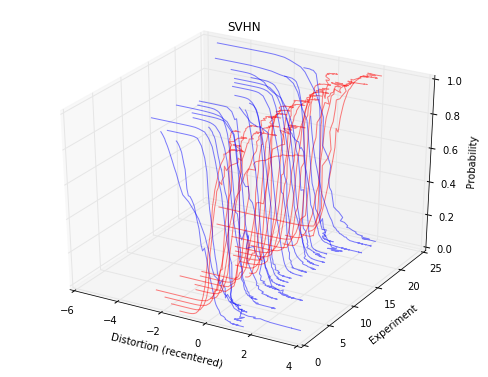

In [81]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(n):
    intersection = np.argmax((orig_prob[i] - adv_prob[i]) >= 0)
    intersection_x = (adv_norm[i][intersection-1] + adv_norm[i][intersection])/2.0
    intersection_y1 = 0#(adv_prob[i][intersection-1] + adv_prob[i][intersection])/2.0
    intersection_y2 = 0#(orig_prob[i][intersection-1] + orig_prob[i][intersection])/2.0
    ax.plot(adv_norm[i]-intersection_x, [i]*len(adv_prob[i]), adv_prob[i]-intersection_y1, color = 'r', alpha = 0.5)
    ax.plot(adv_norm[i]-intersection_x, [i]*len(adv_prob[i]), orig_prob[i]-intersection_y2, color = 'b', alpha = 0.5)

ax.set_xlabel('Distortion (recentered)')
ax.set_ylabel('Experiment')
ax.set_zlabel('Probability')
plt.title("SVHN")
fig.set_figwidth(8.5)
fig.set_figheight(6.5)
plt.show()

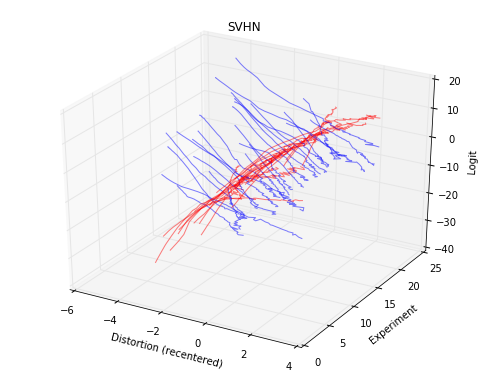

In [82]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(n):
    intersection = np.argmax((orig_prob_logit[i] - adv_prob_logit[i]) >= 0)
    intersection_x = (adv_norm[i][intersection-1] + adv_norm[i][intersection])/2.0
    intersection_y1 = 0#(adv_prob_logit[i][intersection-1] + adv_prob_logit[i][intersection])/2.0
    intersection_y2 = 0#(orig_prob_logit[i][intersection-1] + orig_prob_logit[i][intersection])/2.0
    ax.plot(adv_norm[i]-intersection_x, [i]*len(adv_prob[i]), adv_prob_logit[i]-intersection_y1, color = 'r', alpha = 0.5)
    ax.plot(adv_norm[i]-intersection_x, [i]*len(adv_prob[i]), orig_prob_logit[i]-intersection_y2, color = 'b', alpha = 0.5)

ax.set_xlabel('Distortion (recentered)')
ax.set_ylabel('Experiment')
ax.set_zlabel('Logit')
plt.title("SVHN")
fig.set_figwidth(8.5)
fig.set_figheight(6.5)
plt.show()

Img 6557 Adv label 0


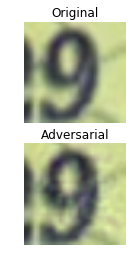

7.05388196117 0.00238382 0.992743


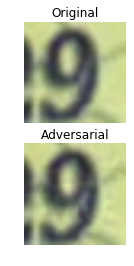

3.86168483138 0.321543 0.205746


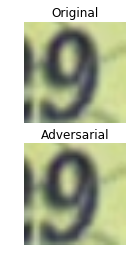

0.0943736298361 0.997231 7.97257e-07


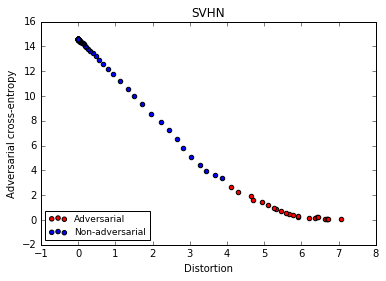

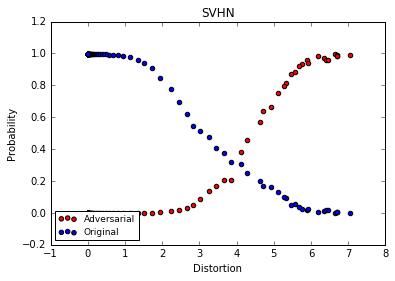

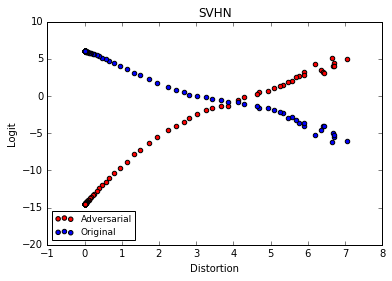

In [83]:
_, _, _, _ = orig_adv_dist(6557, 0, plot = True)